#### Achtung: Dieses Notebook benötigt die _aktuellste_ next-Version von PyDelta

Installation mit

```bash
pip install -U https://github.com/fotis007/pydelta@next
```

In [1]:
%pylab inline
mpl.style.use('ggplot')
import delta
import pandas as pd
import random

Populating the interactive namespace from numpy and matplotlib


In [2]:
de = delta.Corpus('/home/tv/git/pydelta/corpus_DE')
de1000 = de.get_mfw_table(1000)
z = delta.registry.z_score(de1000)

Da wir die z-Scores bereits bestimmt haben, müssen wir nun nur noch 'den Rest' der Funktionen rechnen:

In [3]:
methods = {
    'cosine_delta' : delta.registry.delta('cosine'),
    'burrows_delta': delta.registry.delta('manhattan'),
    'eders_delta'  : delta.CompositeDeltaFunction('manhattan-eder_std', name='eders_delta', register=False),
    'euclidean'    : delta.PDistDeltaFunction('euclidean', register=False)
}

Nun einmal ein Experiment mit Cosine und unmanipuliertem Z-Corpus:

In [4]:
dist = delta.registry.cosine(z)
clust = delta.Clustering(dist).fclustering()
print(dist.evaluate(), clust.evaluate(), sep='\n')

F-Ratio         0.257097
Fisher's LD     2.158003
Simple Score    3.718640
dtype: float64
Cluster Errors         2.000000
Adjusted Rand Index    0.932358
Homogeneity            0.981365
Completeness           0.984136
V Measure              0.982749
Purity                 0.973333
Entropy                0.018635
dtype: float64


### Simulation von Outliern durch Manipulation der z-Scores

Um Outlier zu simulieren, manipulieren wir in der Tabelle der $z$-Scores zunächst zufällig jeweils $n$ verschiedene Werte, indem wir sie deutlich vergrößern.

In [5]:
all_z = z.unstack()
all_z.quantile(0.995), all_z.max(), all_z.min(), all_z.mean()

(3.8276977912881374,
 8.5447839840064717,
 -3.6663227759234687,
 -4.7345830959481344e-17)

Der Plan ist, jeweils $n$ Einträge zufällig zu wählen und sie dabei bei gleichbleibender Richtung zu manipulieren, sagen wir mal um 5.

In [6]:
n = list(range(0,5001,10))

Wir bauen einen Dataframe für die Ergebnisse:

In [7]:
distance_eval = dist.evaluate().index.tolist()
cluster_eval = clust.evaluate().index.tolist()
all_eval = distance_eval + cluster_eval
idx = pd.MultiIndex.from_product([methods.keys(), n], names=['Method', 'Outliers'])
results = pd.DataFrame(index=idx, columns=pd.Index(all_eval))

Für unser Experiment ändern wir im selben Corpus inkrementell die Werte zufällig gewählter Zellen. Dabei vermeiden wir, dasselbe Feature doppelt zu samplen (drum `rand.sample`). Zunächst bereiten wir die Liste der zu fälschenden Felder (als numerische Koordinaten in der Featurematrix) vor:

In [8]:
fake_cells = random.sample(range(0, z.index.size * z.columns.size), n[-1])
fake_coords = [(r // z.columns.size, r % z.columns.size) for r in fake_cells]

Nun für jeden Datenpunkt entsprechend dem ``n`` oben zunächst (erste innere ``for``-Schleife) die _zusätzlichen_ Zellen manipulieren, dann (zweite Schleife) Distanzen und Clusterings berechnen & die Evaluationswerte berechnen:

In [9]:
zz = delta.Corpus(z)
faked = 0    # wieviele Werte haben wir bereits in zz gefälscht?
for n_fakes in n:    
    for manip_count in range(faked, n_fakes): 
        coords = fake_coords[manip_count]        
        # Nun die Zelle an der entsprechenden Stelle um 5 erhöhen/verringern:
        zz.iat[coords] = zz.iat[coords] + np.sign(zz.iat[coords])*5        
        #print("Fälschung {} an {} {} von {} um {} nach {}".format(
        #        manip_count, fake_cells[manip_count], coords, z.iat[coords], add_value, zz.iat[coords]))
    faked = n_fakes
    for method in methods:
        func = methods[method]
        dist = func(zz)
        clust = delta.Clustering(dist).fclustering()
        d_scores = dist.evaluate()
        c_scores = clust.evaluate()
        results.loc[(method, n_fakes), d_scores.index] = d_scores
        results.loc[(method, n_fakes), c_scores.index] = c_scores
        results.loc[(method, n_fakes), 'σ(z)'] = zz.unstack().std()

In [10]:
results

F-Ratio Fisher's LD Simple Score Cluster Errors  \
Method        Outliers                                                     
eders_delta   0         0.394205    0.875785      2.35789              8   
              10        0.394691    0.875217      2.35708              7   
              20          0.3955    0.873674      2.36115              7   
              30        0.395968    0.862553      2.35465              7   
              40        0.396281    0.851809       2.3532              7   
              50        0.396709    0.871755      2.35353              7   
              60        0.396731    0.869296      2.35035              7   
              70        0.397516    0.868022      2.35257              7   
              80        0.398076     0.85704      2.35259              7   
              90        0.398468     0.85742      2.35606              7   
              100        0.39882    0.861197      2.35463              7   
              110       0.399789    0.862732      2.36373              7   
              120       0.399966    0.866765       2.3624              7   
              130       0.400043    0.845269      2.36834              7   
              140       0.400421    0.840782      2.36287              7   
              150       0.400426    0.830874      2.36739              7   
              160        0.40067    0.836945      2.36886              7   
              170       0.401446    0.838046      2.35699              7   
              180       0.402074    0.831039      2.35372              7   
              190       0.402366    0.828249       2.3525              7   
              200       0.402741    0.832383      2.35607              7   
              210       0.403463    0.830042      2.35832              7   
              220       0.403403    0.814355      2.35754              7   
              230       0.403455    0.815054      2.35663              7   
              240       0.404027    0.813003      2.35501              7   
              250        0.40436    0.810659      2.35507              7   
              260       0.404739    0.815722      2.35418              7   
              270       0.405228    0.818802      2.35611              7   
              280       0.405683    0.823264      2.35919              7   
              290       0.406031    0.821951      2.35579              7   
...                          ...         ...          ...            ...   
burrows_delta 4710      0.570398     0.86295      2.41439              7   
              4720      0.570728    0.859777      2.40683              6   
              4730       0.57092    0.850394      2.40802              6   
              4740      0.571398    0.846542      2.40583              6   
              4750      0.571749    0.844878      2.40648              6   
              4760      0.571647     0.86763      2.40943              6   
              4770      0.571655    0.870707      2.40676              6   
              4780      0.571936    0.867945        2.409              5   
              4790      0.572158     0.87063       2.4065              5   
              4800       0.57268    0.870158      2.40778              5   
              4810      0.572768    0.862966      2.41254              5   
              4820      0.572515    0.849504      2.40778              5   
              4830      0.572309    0.862921      2.40889              5   
              4840      0.572483    0.854493      2.41473              5   
              4850      0.572852    0.852302      2.41956              5   
              4860      0.573048    0.843857      2.41726              5   
              4870      0.573515    0.839994      2.41682              5   
              4880      0.574073     0.83945      2.41884              5   
              4890      0.574143    0.830596      2.42507              5   
              4900      0.574102    0.824603      2.43081              5 

[(<matplotlib.axes._subplots.AxesSubplot at 0x7f1f0be26278>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f1f0be44860>),
 (<matplotlib.axes._subplots.AxesSubplot at 0x7f1f0beb0278>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f1f0bebff98>),
 (<matplotlib.axes._subplots.AxesSubplot at 0x7f1f0bfd37f0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f1f0c02fb70>),
 (<matplotlib.axes._subplots.AxesSubplot at 0x7f1f0bfc74a8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f1f0bfefac8>)]

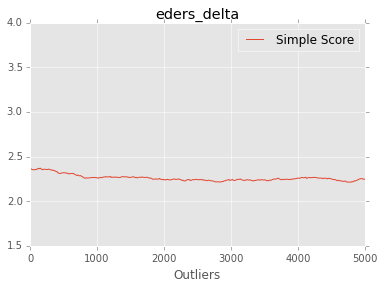

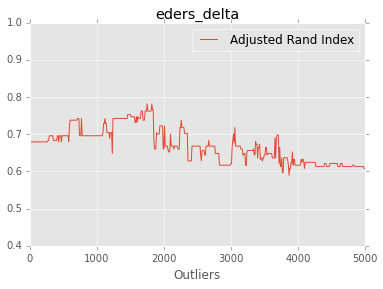

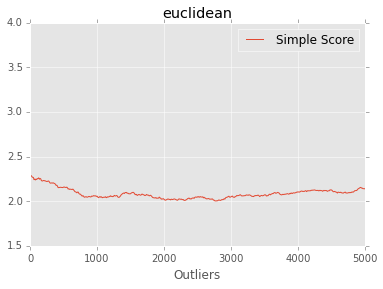

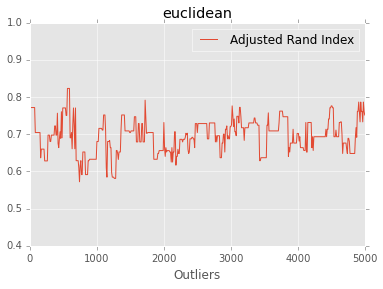

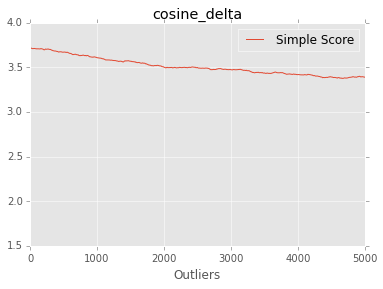

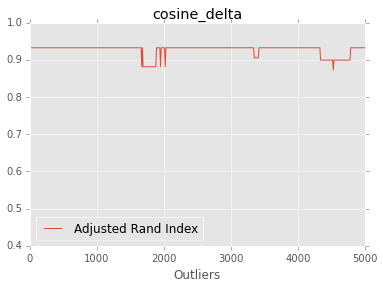

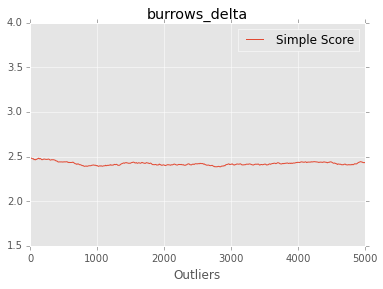

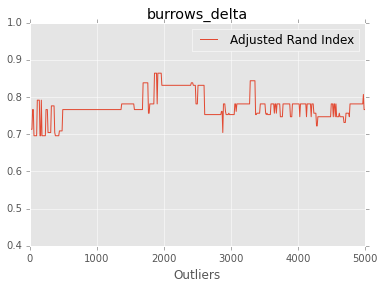

In [11]:
[(results.loc[method].plot.line(y='Simple Score', title=method, ylim=(1.5,4)), 
  results.loc[method].plot.line(y='Adjusted Rand Index', title=method, ylim=(0.4,1))) for method in methods]

In [12]:
z.unstack().std(), zz.unstack().std()

(0.99331758385605551, 1.7709484188894968)